In [1]:
%matplotlib notebook 
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
a= 0.1
def dist(x1,x2,L):
        """compute the distance between 2 birds whose position vectors are x1 and x2,
        with respect to the periodic boundary condition"""
        x=x1[0]
        y=x1[1]
        if abs(x2[0]-x1[0])>L/2:
            x+= np.sign(x2[0]-x1[0])*L 
        x-=x2[0]
        if abs(x2[1]-x1[0])>L/2:
            y+= np.sign(x2[1]-x1[1])*L 
        y-=x2[1]
        d = np.linalg.norm(np.array([x,y]))
        return d
    
    

def V(d):
    if d<a :
        return (1/d -1/a)
    else :
        return 0 
    
"""d is the distance between 2 birds. We chose a < r the interaction radius.
a represents a kind of safety distance that birds need to keep to fly comfortably"""

'd is the distance between 2 birds. We chose a < r the interaction radius.\na represents a kind of safety distance that birds need to keep to fly comfortably'

In [3]:
class Flock(object):
    """Represents the N-birds configuration at a given moment, in 2D. Birds are flocking with a velocity v in a square of side L 
    with periodic boundary conditions. Birds' positions and velocities are contained in two arrays. 
    At t=0, these are pos0 and vel0."""
    
    def __init__(self,N,L,beta,v,r, Dt, dt, pos0, vel0, Potential, alpha):
        """we choose L as a multiple of r in order to simplify"""
        self.positions = pos0
        self.velocities = vel0 
        """normalized velocities"""
        self.a = int(L/r)
        self.checkering = [[[] for i in range(self.a)] for j in range(self.a)]
        self.beta = beta 
        """temperature"""
        self.v = v
        self.r = r 
        """the interaction radius"""
        self.L = L 
        """the scale of the flock"""
        self.N = N
        self.Dt=Dt
        self.dt  = dt
        self.Potential = Potential
        self.alpha = alpha
        self.localize_birds()
        
    def localize_birds(self):
        """compute the cell of each bird from its position and actualize self.checkering"""
        self.checkering = [[[] for i in range(self.a)] for j in range(self.a)]
        for k in range (self.N):
            i,j = int(self.positions[k][0]/self.r),int(self.positions[k][1]/self.r)
            self.checkering[i][j].append(k)
    
            
    def get_energy(self):
        return (0)
        
    def change_velocity(self):
        k = npr.randint(self.N)
        theta=np.arctan(self.velocities[k,1]/self.velocities[k,0])
        """the direction of the bird before the move"""
        theta= theta +(1-np.sign(theta)*np.sign(self.velocities[k,1]))*np.pi/2
        theta_new = theta + npr.uniform(-self.alpha/2,self.alpha/2) 
        """the bird can change its direction within an angle +/- alpha/2"""
        v_new = self.v*np.array([np.cos(theta_new),np.sin(theta_new)])
        De = 0
        i,j = int(self.positions[k][0]/self.r),int(self.positions[k][1]/self.r)
        for p in range(-1,2):
            for q in range (-1,2):
                for bird in self.checkering[(i+p)%self.a][(j+q)%self.a]:
                    if bird!=k :
                        d=dist(self.positions[k],self.positions[bird],self.L)
                        if d <self.r : #check if birds are within a circle of radius r
                            dist_new = dist(self.positions[k]+v_new*self.Dt,self.positions[bird]+self.velocities[bird]*self.Dt,self.L) 
                            #compute the new distance between k and bird, if the change of velocity is accepted
                            De -= -np.dot(self.velocities[k]-v_new,self.velocities[bird])/self.v**2
                            De -= self.Potential(d)
                            De += self.Potential(dist_new)
        A=(np.tanh(-self.beta*De)+1)/2
        if npr.random()<A:
            self.velocities[k]=v_new
        for i in range(self.N):
            self.positions[i]+=self.v*self.velocities[i]*self.dt
            self.positions[i]=(self.positions[i])%self.L
            self.localize_birds()
        
    def step(self):
        for i in range (self.N):
            self.change_velocity()
            
    def compute_avr_norm_velocity(self):
        """compute the average normalized velocity of birds in the flock at time t"""
        va = [0,0]
        for k in range (self.N):
            va+=self.velocities[k]
        return np.linalg.norm(va/(self.N*self.v))
    
    def flock_to_image(flock):  
        plt.figure()
        plt.axis([0,flock.L,0,flock.L])
        plt.quiver(flock.positions[:,0],flock.positions[:,1],flock.velocities[:,0],flock.velocities[:,1], alpha=.5)
        plt.show()

    

        
        
    

<IPython.core.display.Javascript object>


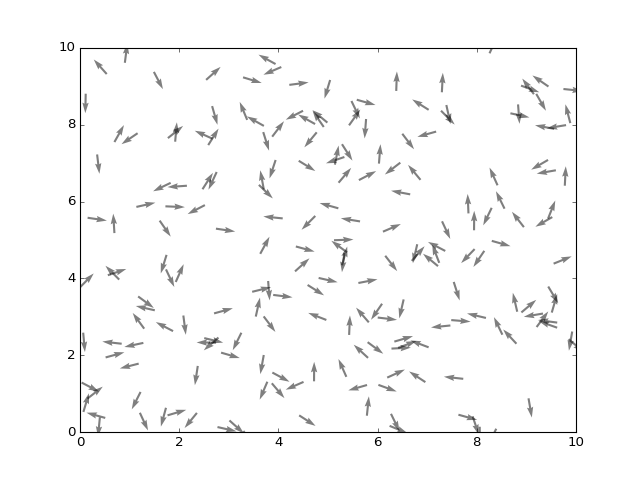

In [4]:
N=200
L=10
beta=0.1
v=1
r=1.
dt =0.005 
Dt=1.
#pos0=np.array([[5.,5.],[2.,3.],[3.,7.]])
pos0=npr.uniform(0,L,size=(N,2))
#vel0=np.array([[1.,0.],[0.5,0.],[1.,0.]])
theta = npr.uniform(0.,2*np.pi,N)
vel0=np.zeros((N,2))
vel0[:,0]=v*np.cos(theta)
vel0[:,1]=v*np.sin(theta)
alpha = np.pi/2
fl=Flock(N,L,beta,v,r, Dt, dt, pos0, vel0, V, alpha)

fl.step()
fl.flock_to_image()



<IPython.core.display.Javascript object>


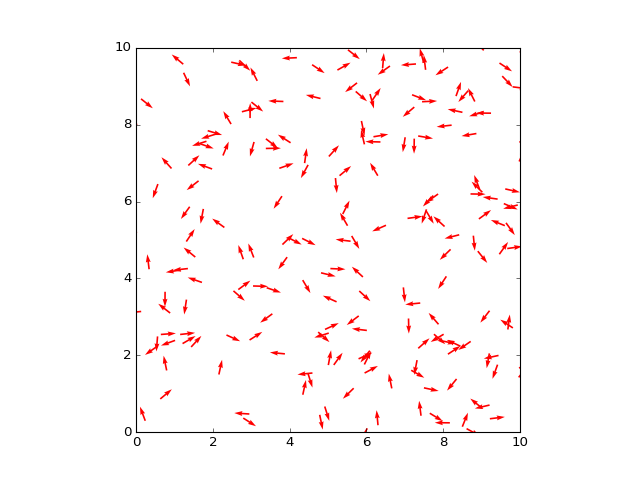

In [6]:
###ANIMATION###


#plot within quiver 

X, Y = fl.positions[:,0], fl.positions[:,1]
U, V = fl.velocities[:,0], fl.velocities[:,1]

#fig, ax = plt.subplots(1,1)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
#line, = ax.plot([], [], 'bo', ms=5)
Q = ax.quiver(X, Y, U, V, color='r')
ax.set_xlim(0, fl.L)
ax.set_ylim(0, fl.L)

def update_quiver(t):
        for i in range(6):
            fl.step()
        X, Y = fl.positions[:,0], fl.positions[:,1]
        U, V = fl.velocities[:,0], fl.velocities[:,1]
        Q.set_UVC(U,V)
        Q.set_offsets(np.stack([X,Y],axis =1))
        return Q,

animation.FuncAnimation(fig, update_quiver,
                               interval=5, blit=False)




In [ ]:
L=[]
T=[]
t=0
for i in range(100):
    T.append(t)
    for k in range (200):
        fl.step()
    L.append(fl.compute_avr_norm_velocity())
    t+=1

    
plt.figure()
plt.plot(T,L)